In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [6]:
root_dir = Path().cwd().parent
interim_dir = root_dir / 'data/interim'
undistorted_dir = interim_dir / 'undistorted'
rectified_dir = interim_dir / 'rectified'
rectified_dir.mkdir(parents=True, exist_ok=True)

In [39]:
def rectifyImages(img1, img2, nb_matches=200):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1_gray, None)
    kp2, des2 = sift.detectAndCompute(img2_gray, None)
    bf = cv2.BFMatcher()
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    pts1 = []
    pts2 = []
    for m in matches[:nb_matches]:
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=1, confidence=0.95)
    pts1 = pts1[mask.ravel() == 1]
    pts2 = pts2[mask.ravel() == 1]
    ret, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(pts1), np.float32(pts2), F, imgSize=img1_gray.shape)
    if ret:
        img1_rect = cv2.warpPerspective(img1, H1, (img1_gray.shape[1], img1_gray.shape[0]))
        img2_rect = cv2.warpPerspective(img2, H2, (img2_gray.shape[1], img2_gray.shape[0]))
        return img1_rect, img2_rect
    else:
        return None, None

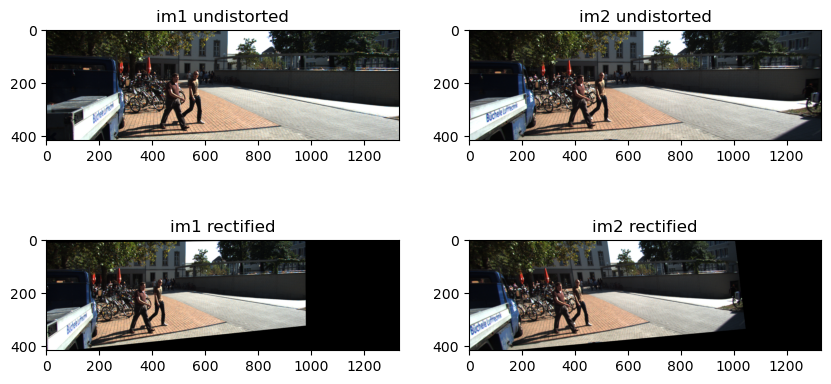

In [40]:
folders = os.listdir(root_dir / 'data/interim/undistorted/seq_01')
images = os.listdir(root_dir / 'data/interim/undistorted/seq_01' / folders[0])[:3]

for k, image in enumerate(images):
    im1 = cv2.imread(str(root_dir / 'data/interim/undistorted/seq_01' / folders[0] / image))
    im2 = cv2.imread(str(root_dir / 'data/interim/undistorted/seq_01' / folders[1] / image))

    im1_rect, im2_rect = rectifyImages(im1, im2)

    if (k == 0):
        fig, axs = plt.subplots(2, 2, figsize=(10,5))
        axs[0, 0].imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
        axs[0, 0].set_title('im1 undistorted')
        axs[0, 1].imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
        axs[0, 1].set_title('im2 undistorted')
        axs[1, 0].imshow(cv2.cvtColor(im1_rect, cv2.COLOR_BGR2RGB))
        axs[1, 0].set_title('im1 rectified')
        axs[1, 1].imshow(cv2.cvtColor(im2_rect, cv2.COLOR_BGR2RGB))
        axs[1, 1].set_title('im2 rectified')